# Pooling and Stacking Effects Analysis

This notebook focuses specifically on analyzing the effects of different pooling strategies and descriptor stacking on performance.

## Key Research Questions:
1. **Pooling Impact**: How does Domain-Size Pooling (DSP) affect descriptor performance?
2. **Stacking Benefits**: Does stacking descriptors improve robustness and accuracy?
3. **Interaction Effects**: How do pooling strategies interact with different descriptor types?
4. **Computational Trade-offs**: Performance gains vs computational cost


In [11]:
# Import required libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# Database connection
DB_PATH = "../../build/experiments.db"

In [12]:
# Load and preprocess experiment data with focus on pooling strategies
def load_pooling_analysis_data():
    conn = sqlite3.connect(DB_PATH)
    
    query = """
    SELECT 
        e.id as experiment_id,
        e.descriptor_type,
        e.pooling_strategy,
        e.dataset_name,
        e.similarity_threshold,
        e.max_features,
        r.mean_average_precision,
        r.true_map_macro,
        r.true_map_micro,
        r.true_map_macro_with_zeros,
        r.true_map_micro_with_zeros,
        r.legacy_mean_precision,
        r.precision_at_1,
        r.precision_at_5,
        r.recall_at_1,
        r.recall_at_5,
        r.total_matches,
        r.total_keypoints,
        r.processing_time_ms,
        r.metadata
    FROM experiments e 
    JOIN results r ON e.id = r.experiment_id
    WHERE e.pooling_strategy IN ('none', 'domain_size_pooling', 'stacking')
    ORDER BY e.descriptor_type, e.pooling_strategy
    """
    
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    # Use primary columns directly, with fallback to legacy for older records
    df['macro_map'] = df['true_map_macro'].fillna(df['mean_average_precision'])
    df['micro_map'] = df['true_map_micro'].fillna(df['mean_average_precision'])
    df['macro_map_with_zeros'] = df['true_map_macro_with_zeros']
    df['micro_map_with_zeros'] = df['true_map_micro_with_zeros']
    
    # Clean and enhance data
    pooling_map = {
        'none': 'None',
        'domain_size_pooling': 'DSP',
        'stacking': 'Stacking'
    }
    df['pooling_clean'] = df['pooling_strategy'].map(pooling_map)
    
    # Extract base descriptor info
    df['base_descriptor'] = df['descriptor_type'].str.extract(r'(sift|rgbsift)', expand=False).str.upper().fillna('SIFT')
    df['uses_color'] = df['descriptor_type'].str.contains('rgb', case=False)
    
    # Calculate performance improvements using macro MAP
    baseline_performance = df[df['pooling_clean'] == 'None'].groupby('base_descriptor')['macro_map'].mean()
    
    def calculate_improvement(row):
        baseline = baseline_performance.get(row['base_descriptor'], row['macro_map'])
        if pd.isna(baseline) or pd.isna(row['macro_map']):
            return 0.0
        return (row['macro_map'] - baseline) / baseline * 100
    
    df['map_improvement_pct'] = df.apply(calculate_improvement, axis=1)
    
    return df

df_pooling = load_pooling_analysis_data()
print(f"Loaded {len(df_pooling)} experiments for pooling analysis")
print(f"Pooling strategies: {sorted(df_pooling['pooling_clean'].unique())}")
print("Available MAP metrics (using primary columns):")
print(f"- Primary MAP: {df_pooling['mean_average_precision'].min():.4f} - {df_pooling['mean_average_precision'].max():.4f}")
print(f"- Macro MAP: {df_pooling['macro_map'].min():.4f} - {df_pooling['macro_map'].max():.4f}")
print(f"- Micro MAP: {df_pooling['micro_map'].min():.4f} - {df_pooling['micro_map'].max():.4f}")
df_pooling.head()

Loaded 40 experiments for pooling analysis
Pooling strategies: ['DSP', 'None', 'Stacking']
Available MAP metrics (using primary columns):
- Primary MAP: 0.3703 - 0.5501
- Macro MAP: 0.3703 - 0.5501
- Micro MAP: 0.3724 - 0.5450


,experiment_id,descriptor_type,pooling_strategy,dataset_name,similarity_threshold,max_features,mean_average_precision,true_map_macro,true_map_micro,true_map_macro_with_zeros,...,processing_time_ms,metadata,macro_map,micro_map,macro_map_with_zeros,micro_map_with_zeros,pooling_clean,base_descriptor,uses_color,map_improvement_pct
0,36,dspsift_baseline_color_dsp_l2,domain_size_pooling,../data/,0.8,2000,0.550113,0.550113,0.544967,0.506100,...,129615.0,compute_time_ms=96668.000000;detect_time_ms=0....,0.550113,0.544967,0.506100,0.493452,DSP,SIFT,False,20.110029
1,37,dspsift_baseline_grayscale_dsp_l1,domain_size_pooling,../data/,0.8,2000,0.550104,0.550104,0.544956,0.506090,...,129211.0,compute_time_ms=95983.000000;detect_time_ms=0....,0.550104,0.544956,0.506090,0.493442,DSP,SIFT,False,20.108107
2,35,dspsift_baseline_grayscale_dsp_l2,domain_size_pooling,../data/,0.8,2000,0.550104,0.550104,0.544956,0.506090,...,129386.0,compute_time_ms=96301.000000;detect_time_ms=0....,0.550104,0.544956,0.506090,0.493442,DSP,SIFT,False,20.108107
3,38,dspsift_color_dsp_l1,domain_size_pooling,../data/,0.8,2000,0.550113,0.550113,0.544967,0.506100,...,130871.0,compute_time_ms=97831.000000;detect_time_ms=0....,0.550113,0.544967,0.506100,0.493452,DSP,SIFT,False,20.110029
4,40,dspsift_color_stacking_l2,stacking,../data/,0.8,2000,0.525271,0.525271,0.521879,0.484795,...,64813.0,compute_time_ms=26107.000000;detect_time_ms=0....,0.525271,0.521879,0.484795,0.472547,Stacking,SIFT,False,14.686261


## Pooling Strategy Performance Comparison

/tmp/ipykernel_17431/1311158567.py:82: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 2].boxplot(map_data, labels=labels_box, patch_artist=True)


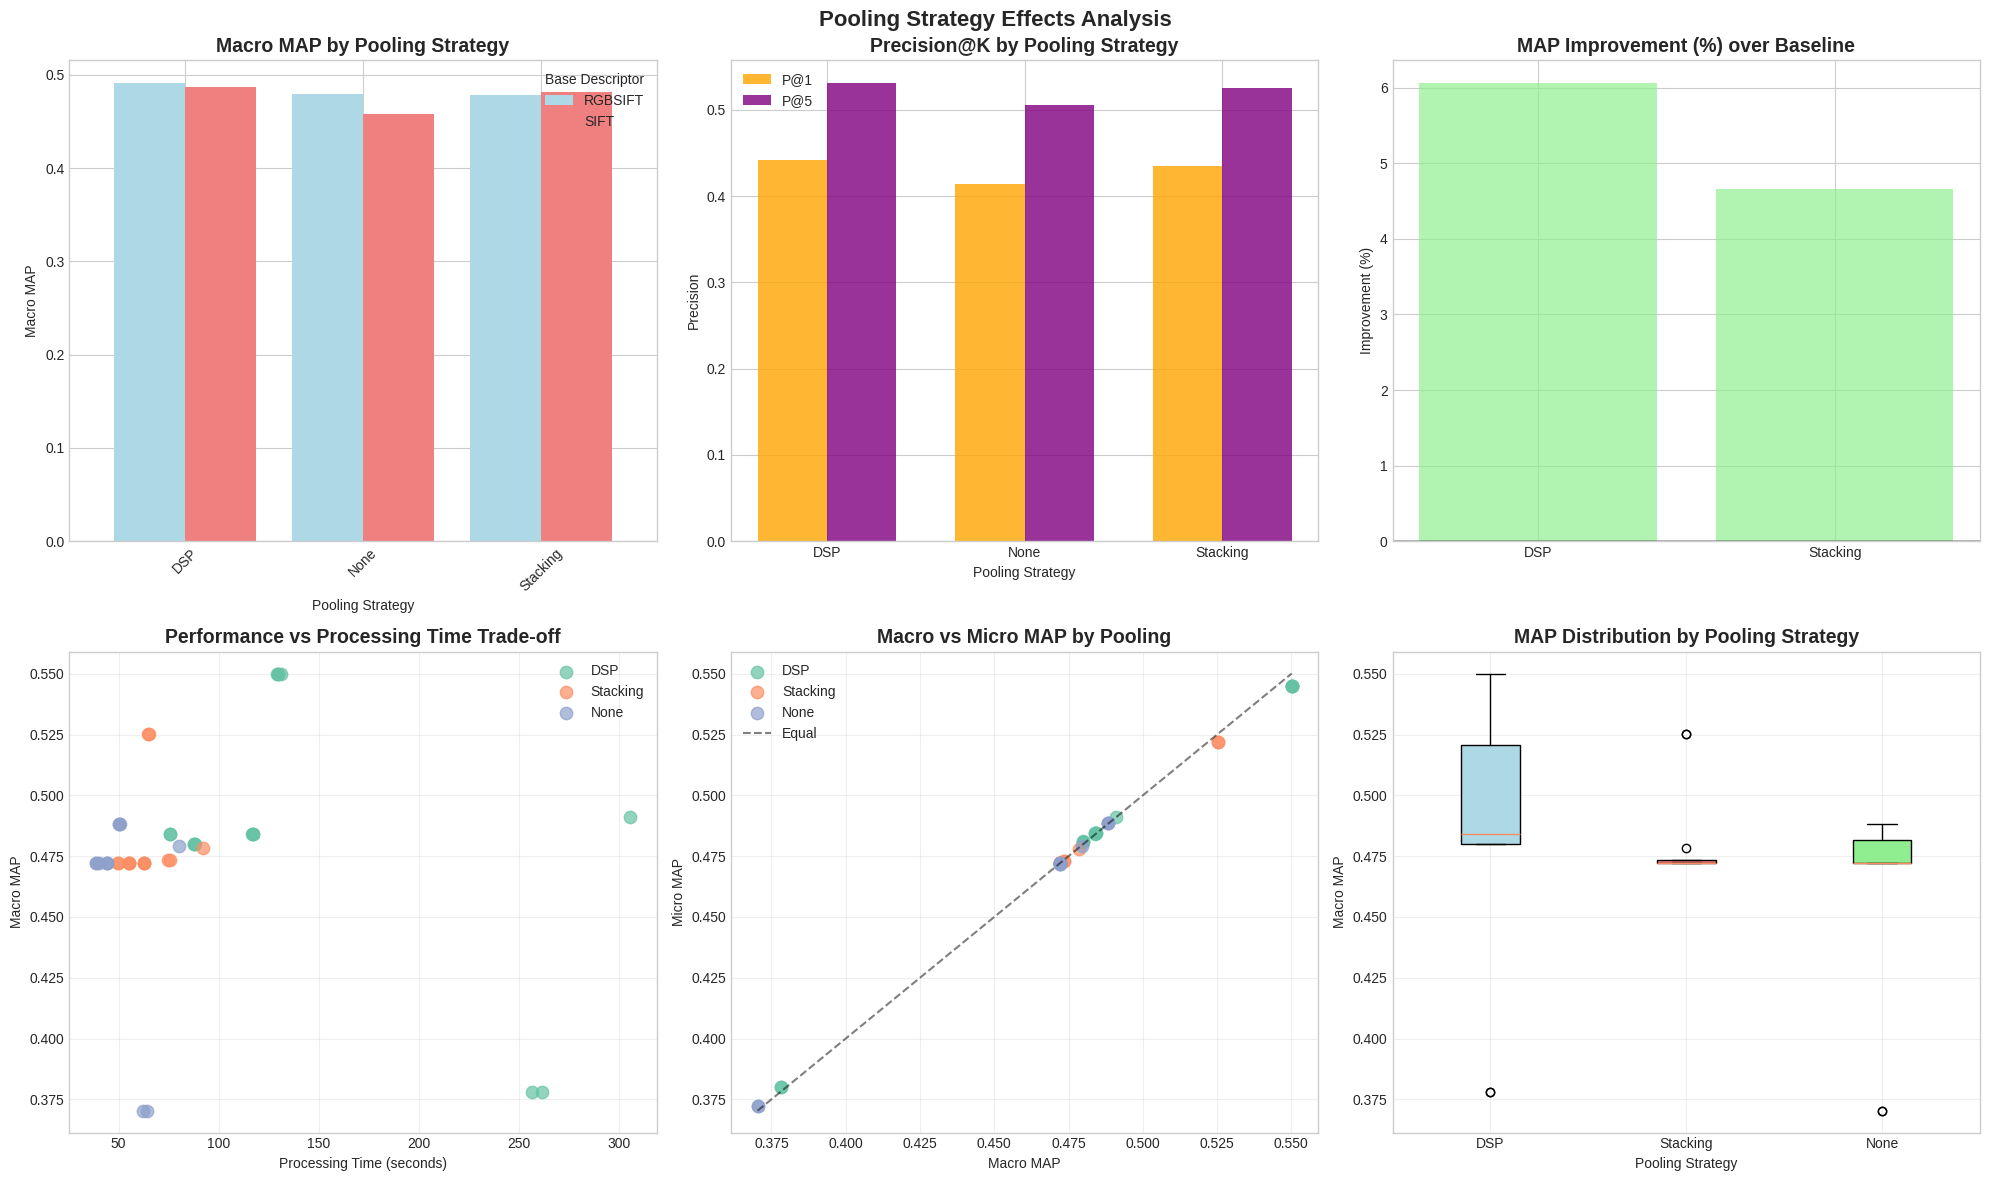

In [13]:
# Create comprehensive pooling effects visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Pooling Strategy Effects Analysis', fontsize=16, fontweight='bold')

# 1. MAP comparison across pooling strategies (using macro MAP)
pooling_comparison = df_pooling.groupby(['pooling_clean', 'base_descriptor'])['macro_map'].mean().unstack(fill_value=0)
pooling_comparison.plot(kind='bar', ax=axes[0, 0], width=0.8, color=['lightblue', 'lightcoral'])
axes[0, 0].set_title('Macro MAP by Pooling Strategy', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Macro MAP')
axes[0, 0].set_xlabel('Pooling Strategy')
axes[0, 0].legend(title='Base Descriptor')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Precision@K comparison
precision_data = df_pooling.groupby('pooling_clean')[['precision_at_1', 'precision_at_5']].mean()
x = np.arange(len(precision_data.index))
width = 0.35
axes[0, 1].bar(x - width/2, precision_data['precision_at_1'], width, label='P@1', alpha=0.8, color='orange')
axes[0, 1].bar(x + width/2, precision_data['precision_at_5'], width, label='P@5', alpha=0.8, color='purple')
axes[0, 1].set_xlabel('Pooling Strategy')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision@K by Pooling Strategy', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(precision_data.index)
axes[0, 1].legend()

# 3. Performance improvement heatmap
improvement_data = []
labels = []
for pooling in df_pooling['pooling_clean'].unique():
    if pooling != 'None':  # Skip baseline
        subset = df_pooling[df_pooling['pooling_clean'] == pooling]
        if len(subset) > 0:
            improvement_data.append(subset['map_improvement_pct'].mean())
            labels.append(pooling)

if improvement_data:
    colors = ['lightgreen' if x > 0 else 'lightcoral' for x in improvement_data]
    axes[0, 2].bar(labels, improvement_data, color=colors, alpha=0.7)
    axes[0, 2].set_title('MAP Improvement (%) over Baseline', fontsize=14, fontweight='bold')
    axes[0, 2].set_ylabel('Improvement (%)')
    axes[0, 2].axhline(y=0, color='black', linestyle='-', alpha=0.3)

# 4. Processing time vs performance trade-off
for pooling in df_pooling['pooling_clean'].unique():
    data = df_pooling[df_pooling['pooling_clean'] == pooling]
    axes[1, 0].scatter(data['processing_time_ms']/1000, data['macro_map'], 
               label=pooling, alpha=0.7, s=80)
axes[1, 0].set_xlabel('Processing Time (seconds)')
axes[1, 0].set_ylabel('Macro MAP')
axes[1, 0].set_title('Performance vs Processing Time Trade-off', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Macro vs Micro MAP comparison by pooling
for pooling in df_pooling['pooling_clean'].unique():
    data = df_pooling[df_pooling['pooling_clean'] == pooling]
    if not data.empty:
        axes[1, 1].scatter(data['macro_map'], data['micro_map'], 
                          label=pooling, alpha=0.7, s=80)

# Add diagonal reference line
min_map = min(df_pooling['macro_map'].min(), df_pooling['micro_map'].min())
max_map = max(df_pooling['macro_map'].max(), df_pooling['micro_map'].max())
axes[1, 1].plot([min_map, max_map], [min_map, max_map], 'k--', alpha=0.5, label='Equal')
axes[1, 1].set_xlabel('Macro MAP')
axes[1, 1].set_ylabel('Micro MAP')
axes[1, 1].set_title('Macro vs Micro MAP by Pooling', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Box plot of MAP distribution by pooling strategy
map_data = []
labels_box = []
for pooling in df_pooling['pooling_clean'].unique():
    data = df_pooling[df_pooling['pooling_clean'] == pooling]['macro_map'].dropna()
    if len(data) > 0:
        map_data.append(data.values)
        labels_box.append(pooling)

if map_data:
    bp = axes[1, 2].boxplot(map_data, labels=labels_box, patch_artist=True)
    colors = ['lightblue', 'lightcoral', 'lightgreen']
    for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
        patch.set_facecolor(color)
    axes[1, 2].set_title('MAP Distribution by Pooling Strategy', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Pooling Strategy')
    axes[1, 2].set_ylabel('Macro MAP')
    axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Statistical Analysis of Pooling Effects

In [14]:
# Statistical analysis of pooling strategy effects
print("=== POOLING STRATEGY EFFECTS ANALYSIS ===")

# 1. Overall performance by pooling strategy
print("\n1. Performance Summary by Pooling Strategy:")
pooling_summary = df_pooling.groupby('pooling_clean').agg({
    'macro_map': ['mean', 'std', 'count'],
    'micro_map': ['mean', 'std', 'count'],
    'mean_average_precision': ['mean', 'std', 'count'],
    'precision_at_1': ['mean', 'std'],
    'precision_at_5': ['mean', 'std'],
    'processing_time_ms': ['mean', 'std'],
    'map_improvement_pct': ['mean', 'std']
}).round(4)
print(pooling_summary)

# 2. Key Performance Insights
print("\n2. Key Performance Insights:")
best_macro = df_pooling.loc[df_pooling['macro_map'].idxmax()]
best_micro = df_pooling.loc[df_pooling['micro_map'].idxmax()]
print(f"Best Macro MAP: {best_macro['macro_map']:.4f} ({best_macro['pooling_clean']} pooling)")
print(f"Best Micro MAP: {best_micro['micro_map']:.4f} ({best_micro['pooling_clean']} pooling)")

# Performance improvements vs baseline
baseline_macro = df_pooling[df_pooling['pooling_clean'] == 'None']['macro_map'].mean()
baseline_micro = df_pooling[df_pooling['pooling_clean'] == 'None']['micro_map'].mean()

for strategy in ['DSP', 'Stacking']:
    if strategy in df_pooling['pooling_clean'].values:
        strategy_data = df_pooling[df_pooling['pooling_clean'] == strategy]
        if len(strategy_data) > 0:
            macro_improvement = ((strategy_data['macro_map'].mean() - baseline_macro) / baseline_macro) * 100
            micro_improvement = ((strategy_data['micro_map'].mean() - baseline_micro) / baseline_micro) * 100
            print(f"{strategy} vs None improvement: {macro_improvement:.2f}% (macro), {micro_improvement:.2f}% (micro)")

# 3. Processing Efficiency Analysis
print("\n3. Processing Efficiency Analysis:")
df_pooling['macro_map_per_second'] = df_pooling['macro_map'] / (df_pooling['processing_time_ms'] / 1000)
efficiency_summary = []

for strategy in df_pooling['pooling_clean'].unique():
    subset = df_pooling[df_pooling['pooling_clean'] == strategy]
    if len(subset) > 0:
        mean_eff = subset['macro_map_per_second'].mean()
        std_eff = subset['macro_map_per_second'].std() if len(subset) > 1 else 0.0
        avg_time = subset['processing_time_ms'].mean() / 1000
        efficiency_summary.append({
            'strategy': strategy,
            'efficiency': mean_eff,
            'efficiency_std': std_eff,
            'avg_time_s': avg_time,
            'sample_size': len(subset)
        })

efficiency_df = pd.DataFrame(efficiency_summary)
print(efficiency_df.round(6))

# 4. Pooling Strategy Ranking
print("\n4. Pooling Strategy Ranking (by Macro MAP):")
ranking = df_pooling.groupby('pooling_clean').agg({
    'macro_map': 'mean',
    'processing_time_ms': 'mean',
    'map_improvement_pct': 'mean'
}).sort_values('macro_map', ascending=False)

for i, (strategy, data) in enumerate(ranking.iterrows(), 1):
    time_cost = data['processing_time_ms'] / 1000
    improvement = data['map_improvement_pct']
    print(f"{i}. {strategy}: {data['macro_map']:.4f} MAP ({improvement:+.2f}% vs baseline, {time_cost:.1f}s)")

# 5. Statistical significance (if we have enough data)
print("\n5. Statistical Analysis:")
pooling_groups = [group['macro_map'].dropna().values for name, group in df_pooling.groupby('pooling_clean')]
group_sizes = [len(group) for group in pooling_groups]

if all(size >= 1 for size in group_sizes) and len(pooling_groups) > 1:
    if all(size >= 2 for size in group_sizes):
        try:
            f_stat, p_value = stats.f_oneway(*pooling_groups)
            print(f"ANOVA F-statistic: {f_stat:.4f}")
            print(f"P-value: {p_value:.4f}")
            print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
        except:
            print("ANOVA could not be computed with current data")
    else:
        print("Insufficient data for ANOVA (need at least 2 samples per group)")
        print(f"Group sizes: {dict(zip(df_pooling['pooling_clean'].unique(), group_sizes))}")
else:
    print("Statistical tests require multiple groups with valid data")

# 6. Effect Sizes (Cohen's d) where possible
print("\n6. Effect Sizes (Cohen's d):")
none_group = df_pooling[df_pooling['pooling_clean'] == 'None']['macro_map'].dropna()
for strategy in ['DSP', 'Stacking']:
    if strategy in df_pooling['pooling_clean'].values:
        treatment_group = df_pooling[df_pooling['pooling_clean'] == strategy]['macro_map'].dropna()
        if len(treatment_group) > 0 and len(none_group) > 0:
            if len(none_group) > 1 or len(treatment_group) > 1:
                pooled_std = np.sqrt(((len(none_group)-1)*none_group.var() + 
                                     (len(treatment_group)-1)*treatment_group.var()) / 
                                    max(1, len(none_group) + len(treatment_group) - 2))
                if pooled_std > 0:
                    cohens_d = (treatment_group.mean() - none_group.mean()) / pooled_std
                    effect_size = "Small" if abs(cohens_d) < 0.5 else "Medium" if abs(cohens_d) < 0.8 else "Large"
                    print(f"{strategy} vs None: Cohen's d = {cohens_d:.3f} ({effect_size} effect)")
                else:
                    mean_diff = treatment_group.mean() - none_group.mean()
                    print(f"{strategy} vs None: Mean difference = {mean_diff:.4f} (Cohen's d undefined - no variance)")
            else:
                print(f"{strategy} vs None: Insufficient variance for Cohen's d calculation")

=== POOLING STRATEGY EFFECTS ANALYSIS ===

1. Performance Summary by Pooling Strategy:
              macro_map               micro_map                \
                   mean     std count      mean     std count   
pooling_clean                                                   
DSP              0.4872  0.0533    15    0.4864  0.0510    15   
None             0.4598  0.0424    12    0.4601  0.0416    12   
Stacking         0.4810  0.0197    13    0.4803  0.0185    13   

              mean_average_precision               precision_at_1          \
                                mean     std count           mean     std   
pooling_clean                                                               
DSP                           0.4872  0.0533    15         0.4418  0.0532   
None                          0.4598  0.0424    12         0.4140  0.0426   
Stacking                      0.4810  0.0197    13         0.4354  0.0198   

              precision_at_5         processing_time_ms    

## Interaction Effects Analysis

In [5]:
# Analyze interaction between pooling strategies and descriptor characteristics
print("=== INTERACTION EFFECTS ANALYSIS ===")

# 1. Pooling × Color interaction
print("\n1. Pooling Strategy × Color Usage Interaction:")
interaction_data = df_pooling.groupby(['pooling_clean', 'uses_color'])['mean_average_precision'].agg(['mean', 'std', 'count'])
print(interaction_data.round(4))

# Visualize interaction
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Interaction plot
for color_usage in [True, False]:
    data = df_pooling[df_pooling['uses_color'] == color_usage]
    pooling_means = data.groupby('pooling_clean')['mean_average_precision'].mean()
    axes[0].plot(pooling_means.index, pooling_means.values, 
                marker='o', linewidth=2, markersize=8,
                label=f"{'Color' if color_usage else 'Grayscale'}")

axes[0].set_xlabel('Pooling Strategy')
axes[0].set_ylabel('Mean Average Precision')
axes[0].set_title('Pooling × Color Usage Interaction', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Heatmap of interaction effects
interaction_pivot = df_pooling.pivot_table(
    values='mean_average_precision', 
    index='pooling_clean', 
    columns='uses_color', 
    aggfunc='mean'
)
sns.heatmap(interaction_pivot, annot=True, cmap='Blues', fmt='.3f', ax=axes[1])
axes[1].set_title('Performance Heatmap: Pooling × Color', fontweight='bold')
axes[1].set_xlabel('Uses Color')

plt.tight_layout()
plt.show()

# 2. Best performing combinations
print("\n2. Top Performing Descriptor + Pooling Combinations:")
combination_performance = df_pooling.groupby(['descriptor_type', 'pooling_clean']).agg({
    'mean_average_precision': 'mean',
    'precision_at_1': 'mean',
    'processing_time_ms': 'mean'
}).reset_index()

top_combinations = combination_performance.nlargest(5, 'mean_average_precision')
print(top_combinations.round(4))

=== INTERACTION EFFECTS ANALYSIS ===

1. Pooling Strategy × Color Usage Interaction:


NameError: name 'df_pooling' is not defined

In [6]:
# Export pooling analysis results
output_dir = Path("../outputs")
output_dir.mkdir(exist_ok=True)

# Save detailed pooling analysis data
df_pooling.to_csv(output_dir / "pooling_effects_analysis.csv", index=False)

# Save summary statistics
pooling_summary.to_csv(output_dir / "pooling_strategy_summary.csv")

# Save top combinations
top_combinations.to_csv(output_dir / "top_descriptor_pooling_combinations.csv", index=False)

print(f"\nPooling analysis results exported to {output_dir}")
print(f"Key findings:")
print(f"- Total experiments analyzed: {len(df_pooling)}")
print(f"- Pooling strategies tested: {len(df_pooling['pooling_clean'].unique())}")
print(f"- Descriptor variations: {len(df_pooling['descriptor_type'].unique())}")
print(f"- Best performing combination: {top_combinations.iloc[0]['descriptor_type']} with {top_combinations.iloc[0]['pooling_clean']} (MAP: {top_combinations.iloc[0]['mean_average_precision']:.3f})")

NameError: name 'df_pooling' is not defined